# Create and Evaluate DIKI Large using Word Embeddings

Meta information removed for blind review.

In [1]:
import pandas as pd

#### Read DIKI small

In [2]:
df = pd.read_csv('DIKI_small.csv')

In [3]:
df.head()

,key words
0,"""absurdistan"""
1,"""bild-dungsbürger"""
2,"""eierlosen"""
3,"""entsorgen"""
4,"""entsorgt"""


In [4]:
len(df)

2874

In [5]:
diki_small_low = list(df["key words"])

In [6]:
diki_small_low[:20]

['"absurdistan"',
 '"bild-dungsbürger"',
 '"eierlosen"',
 '"entsorgen"',
 '"entsorgt"',
 '"flüchtling"',
 '"flüchtlinge"',
 '"friedenstaube"',
 '"gästen"',
 '"heimkehrer"',
 '"integrieren"',
 '"männergruppen"',
 '"pirat"',
 '"schiffbrüchigen"',
 '"schutzberechtigten"',
 '"sozialpopulist"',
 '"spitzenmann"',
 '"wähler"',
 '"zecken"',
 '"ziegenhirten"']

## Extend DIKI Small with the Help of Word Embeddings

In [7]:
import gensim
from gensim.models.wrappers import FastText

In [8]:
%%time
model = FastText.load_fasttext_format('cc.de.300.bin') #from https://fasttext.cc/docs/en/crawl-vectors.html

Wall time: 2min 30s


In [9]:
model.most_similar("gepisst", topn=10) #test lol

[('abgepisst', 0.8173563480377197),
 ('vollgepisst', 0.7921205759048462),
 ('gepinkelt', 0.7558916807174683),
 ('gekackt', 0.7330619096755981),
 ('pisst', 0.7125478982925415),
 ('pissen', 0.7026624083518982),
 ('bepisst', 0.6910557150840759),
 ('pisse', 0.6593301296234131),
 ('gepullert', 0.6518568396568298),
 ('angepisst', 0.6470769047737122)]

## Grid Search for Optimal Parameter Setting

#### Load Test Data

In [10]:
df_test = pd.read_csv('GermEval21_TestData.csv') 

In [11]:
#inspect
print(df_test.shape)
df_test.head()

(944, 5)


,comment_id,comment_text,Sub1_Toxic,Sub2_Engaging,Sub3_FactClaiming
0,3245,@USER Sie würden wahrscheinlich auch einen Kri...,1,1,0
1,3246,"@USER , ich glaube,Sie verkrnnen gründlich die...",0,1,1
2,3247,@USER: Man kann natürlich immerzu dieselbe Sau...,0,1,1
3,3248,"Als jemand, der im real existierenden Sozialis...",1,0,0
4,3249,Ihr größter Erfolg in ihrem Leben? KLASSENSPRE...,1,0,0


In [12]:
df_test = df_test[["comment_text", "Sub1_Toxic"]] #We only need the column Toxic

In [13]:
df_test["Sub1_Toxic"].value_counts()

0    594
1    350
Name: Sub1_Toxic, dtype: int64

#### Function to Match Entries with Test Data

In [14]:
def match_unigrams_dicho(X = df_test["comment_text"], dic=diki_small_low):
    
    '''
    Takes a list of words and matches it with the text of each columns of a data frame.
    Returns 0 or 1 for each column. A match is count, if a word "is in" the text.
    
    '''
    
    matches=[]
    
    for index,comment in X.iteritems():
    
        text = str.lower(comment)
        matches_temp = []

        for i in dic:

            if i in text:
                matches_temp.append(1)
            else:
                matches_temp.append(0)
                
        if sum(matches_temp) > 0:
            matches.append(1)
           # print(sum(matches_temp))
        else:
            matches.append(0)
            
            
    return matches

#### Find optimal Threshold for Consine Similarity

In [18]:
#Function for grid-search to define optimal values for a) cosine similarity and b) respective max. number of synonyms.

from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

def grid_search_cosine(model, diki_small_low, y =df_test["Sub1_Toxic"], topn=2): #We start with max. two synonyms.
    
    cosine_list = []
    synonyms_list_len = []
    
    f1_scores =[]
    recall_scores = []
    precision_scores = []
    roc_auc_scores = []
    
    cosine = 0.5 #Synonyms should have at least 0.5 cosine similarity.
    
    while cosine <= 1.0: 
        top_snonyms_list = []

        for i in diki_small_low:
            try:
                top_snonyms= model.most_similar(i, topn=topn)
                top_snonyms_list.append(top_snonyms)
            except:
                pass
    
        synonyms_list=[]

        for i in [item for sublist in top_snonyms_list for item in sublist]:
            
            if i[1] > cosine:
                synonyms_list.append(i)
                

        synonyms_list_low = list(set([x[0].lower() for x in synonyms_list])) #make lower case and remove duplicates
        synonyms_list_len.append(len(synonyms_list_low))

        DIKI_large_temp = list(set(synonyms_list_low + diki_small_low))

        matches = match_unigrams_dicho(X = df_test["comment_text"], dic=DIKI_large_temp)

        
        #Evaluate
        f1 = f1_score(y, matches, average='macro')
        f1_scores.append(f1)
        
        recall = recall_score(y, matches)
        recall_scores.append(recall)
        
        precision = precision_score(y, matches)
        precision_scores.append(precision)
        
        roc_auc = roc_auc_score(y, matches)
        roc_auc_scores.append(roc_auc)
        
        

        cosine_list.append(cosine)
        
        # add new value to the loop
        cosine = cosine + 0.1  
    
    
    return cosine_list, synonyms_list_len, f1_scores, recall_scores, precision_scores, roc_auc_scores

In [19]:
%%time #Will take a couple of hours.

#We create a file including the outcomes of all interations.
df_eval_all=pd.DataFrame(columns=['Cosine', 'Nr_synonyms', 'F1', "Recall", "roc_auc", "Precision", "top_n"])
for i in range(2,10,1): #In every interation, we increase the max. number of synonyms up to 10.
    
    cosine_list, synonyms_list_len, f1_scores, recall_scores, precision_scores, roc_auc_scores = grid_search_cosine(model, diki_small_low, y =df_test["Sub1_Toxic"], topn=i)
    #print(i)
    df_eval = pd.DataFrame({"Cosine": cosine_list, 
                        "Nr_synonyms" : synonyms_list_len, 
                        "F1":f1_scores,
                        "Recall": recall_scores,
                        "roc_auc": roc_auc_scores,
                        "Precision":precision_scores,
                        "top_n":i})
    df_eval_all = pd.concat([df_eval_all,df_eval])

Wall time: 6h 37min 20s


In [21]:
df_eval_all.to_csv("table_evaluation_gridsearch.csv", index=None)
#df_eval_all.to_excel("table_evaluation_gridsearch.xlsx", index=None)

In [22]:
#import pandas as pd
df = pd.read_csv("table_evaluation_gridsearch.csv")

In [24]:
df = df.sort_values(by="Nr_synonyms", ignore_index=True)
df #Results from all runs.

,Cosine,Nr_synonyms,F1,Recall,roc_auc,Precision,top_n
0,1.0,0,0.611791,0.602857,0.619610,0.494145,5
1,1.0,0,0.611791,0.602857,0.619610,0.494145,8
2,1.0,0,0.611791,0.602857,0.619610,0.494145,7
3,1.0,0,0.611791,0.602857,0.619610,0.494145,6
4,1.0,0,0.611791,0.602857,0.619610,0.494145,4
5,1.0,0,0.611791,0.602857,0.619610,0.494145,3
6,1.0,0,0.611791,0.602857,0.619610,0.494145,9
7,1.0,0,0.611791,0.602857,0.619610,0.494145,2
8,0.9,5,0.611791,0.602857,0.619610,0.494145,2
9,0.9,6,0.611791,0.602857,0.619610,0.494145,3


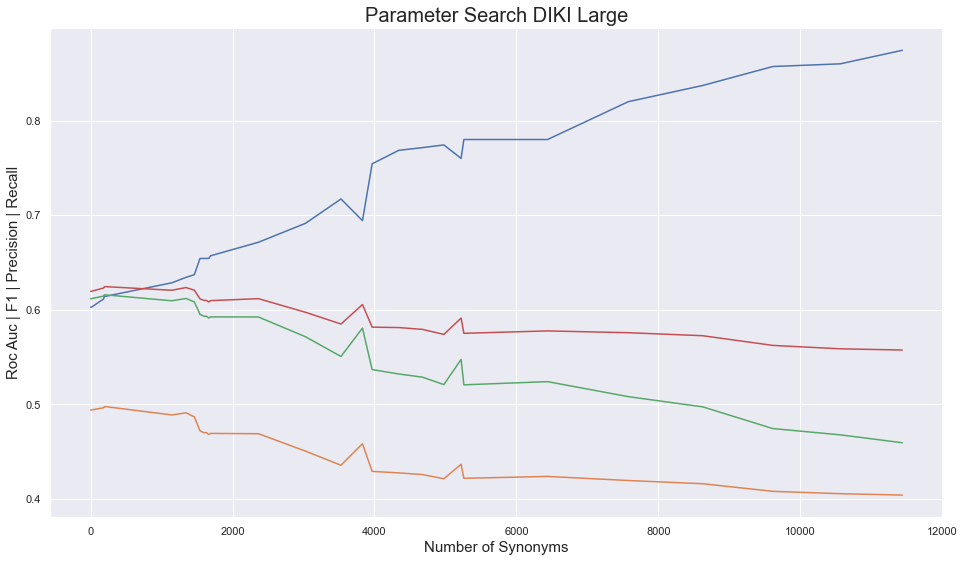

In [25]:
import matplotlib.pyplot as plt #visualization of loss/increase of different performance metrics
import seaborn as sns


plt.figure(figsize = (16,9))
sns.set(style='darkgrid',)
 
sns.lineplot(x = "Nr_synonyms", y = "Recall", data = df, palette = "blue", dashes = False, legend="brief",)
sns.lineplot(x = "Nr_synonyms", y = "Precision", data = df, palette = "red", dashes = False, legend="brief",)
sns.lineplot(x = "Nr_synonyms", y = "F1", data = df, palette = "rocket", dashes = False, legend="brief")
sns.lineplot(x = "Nr_synonyms", y = "roc_auc", data = df, palette = "rocket", dashes = False, legend="brief")


plt.title("Parameter Search DIKI Large", fontsize = 20)
plt.xlabel("Number of Synonyms", fontsize = 15)
plt.ylabel("Roc Auc | F1 | Precision | Recall", fontsize = 15)
plt.show()

### Create DIKI large based on grid search results 

In [26]:
top_snonyms_list = []
#synonyms_list_len = []
    
for i in diki_small_low:
    try:
        top_snonyms= model.most_similar(i, topn=3) #Max. number of synonyms, see table 
        top_snonyms_list.append(top_snonyms)
    except:
        pass

synonyms_list=[]

for i in [item for sublist in top_snonyms_list for item in sublist]:

    if i[1] > 0.5: #Cosine must be higher than 0.5, see table
        synonyms_list.append(i)


synonyms_list_low = list(set([x[0].lower() for x in synonyms_list])) #make lower case and remove duplicates
#synonyms_list_len.append(len(synonyms_list_low))

DIKI_large_temp = list(set(synonyms_list_low + diki_small_low))


In [27]:
len(synonyms_list_low)

5221

In [28]:
synonyms_list_low[-30:] #These are the synonyms that have been retrieved.

['hilberger',
 'strassenhändler',
 'doofer',
 'dickbäuchigen',
 'schlägertruppen',
 'rassenschänder',
 'molkereigenossenschaften',
 'führungsunterstützungstruppen',
 'vollschmieren',
 'namensschnullerketten',
 'fettigen',
 'ablehnenswert',
 'ungehorsam',
 'gelenkarthrose',
 'abgewiesenen',
 'ebersberg',
 'gohan',
 'nehmerland',
 'fremdscham',
 'familiengeschichte',
 'wegsperren',
 'bornierte',
 'brillenmodellen',
 'saublöden',
 'propagandatruppe',
 'philanthropia',
 'freundschaftsgeschichten',
 'einsperrt',
 'zensursula',
 'genderqueere']

In [33]:
#We will perform an additional manual check on DIKI large before publishing. See evaluation note book.

df_DIKI_synonyms = pd.DataFrame({'key words':synonyms_list_low})
#df_DIKI_synonyms.to_csv("DIKI_large_for_manual_check02.csv", index=None, encoding="utf-8")
#df_DIKI_synonyms.to_excel("DIKI_large_for_manual_check02.xlsx", index=None, encoding="utf-8")
df_DIKI_synonyms

,key words
0,sexistisch
1,egomanische
2,rosstäuscherei
3,blablablabla
4,rassist
...,...
5216,philanthropia
5217,freundschaftsgeschichten
5218,einsperrt
5219,zensursula


In [35]:
#Save final DIKI large 
DIKI_large = list(set(list(df_DIKI_synonyms["key words"]) + diki_small_low))
len(DIKI_large)

7124

In [36]:
df_DIKIlarge = pd.DataFrame({'key words':DIKI_large})
df_DIKIlarge

,key words
0,sexistisch
1,egomanische
2,#schwuchtel
3,rosstäuscherei
4,untermensch
...,...
7119,freundschaftsgeschichten
7120,einsperrt
7121,zensursula
7122,asyantenverbrechen


In [37]:
df_DIKIlarge.to_excel("DIKI_large.xlsx", index=None, encoding="utf-8")
df_DIKIlarge.to_csv("DIKI_large.csv", index=None, encoding="utf-8")